In [1]:
import creatingFeatures as cf
import re
import math
import pandas as pd
import numpy as np

In [2]:
fileNames = ["TR_neg_SPIDER", "TR_pos_SPIDER", "TS_neg_SPIDER", "TS_pos_SPIDER"]
featureNames = "AAC,DPC,CTD,PAAC,APAAC,RSacid,RSpolar,RSsecond,RScharge,RSDHP".split(',')
labels = ['Positive', 'Negative']

In [3]:
# Load scikit's classifier libraries
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support

from sklearn.preprocessing import MinMaxScaler

In [4]:
def read_fasta(file):
    line1 = open("./data/" + file + ".txt").read().split('>')[1:]
    line2 = [item.split('\n')[0:-1] for item in line1]
    fasta = [[item[0], re.sub('[^ACDEFGHIKLMNPQRSTVWY]', '', ''.join(item[1:]).upper())] for item in line2]
    return fasta


def createFeatureVectors(fasta, sign):
    feat = cf.Features()

    feat_AAC = feat.AAC(fasta)[0]
    feat_DPC = feat.DPC(fasta, 0)[0]
    feat_CTD = np.hstack((feat.CTDC(fasta)[0], feat.CTDD(fasta)[0], feat.CTDT(fasta)[0]))
    feat_PAAC = feat.PAAC(fasta, 1)[0]
    feat_APAAC = feat.APAAC(fasta, 1)[0]
    feat_RSacid = feat.reducedACID(fasta)
    feat_RSpolar = feat.reducedPOLAR(fasta)
    feat_RSsecond = feat.reducedSECOND(fasta)
    feat_RScharge = feat.reducedCHARGE(fasta)
    feat_RSDHP = feat.reducedDHP(fasta)

    feat_list = [feat_AAC,
                 feat_DPC,
                 feat_CTD,
                 feat_PAAC,
                 feat_APAAC,
                 feat_RSacid,
                 feat_RSpolar,
                 feat_RSsecond,
                 feat_RScharge,
                 feat_RSDHP]

    # print([len(item[0]) for item in feat_list])

    df_main = pd.DataFrame()
    for i, item in enumerate(feat_list):
        df = pd.DataFrame(item, columns=[f"{featureNames[i]}_{id}" for id in range(1, len(item[0]) + 1)])
        df_main = pd.concat([df_main, df], axis=1)

    df_main["TARGET"] = 1 if sign == "+" else 0

    return df_main


def createDataset(dataframes):
    df_final = pd.DataFrame()
    for df in dataframes:
        # df_tmp = df[[col for col in df.columns if col.startswith(feature)]]
        df_final = pd.concat([df_final, df], axis=0, ignore_index=True)

    return df_final


def scaleAllFeatures(feature_vecs):
    scaler = MinMaxScaler()
    scaler.fit_transform(feature_vecs)

    return scaler

In [58]:
def initializeModels():
    ET_clf = ExtraTreesClassifier(random_state=0)
    SVM_clf = SVC(random_state=0, C=10, probability=True)
    RF_clf = RandomForestClassifier(n_jobs=2, random_state=0)
    LR_reg = LogisticRegression(solver='lbfgs', max_iter=1000)

    return [RF_clf, SVM_clf, LR_reg, ET_clf]


def cv(clf, X, y, nr_fold):
    ix = []
    for i in range(0, len(y)):
        ix.append(i)
    ix = np.array(ix)

    allACC = []
    allSENS = []
    allSPEC = []
    allMCC = []
    allAUC = []
    allF1 = []

    for j in range(0, nr_fold):
        train_ix = ((ix % nr_fold) != j)
        test_ix = ((ix % nr_fold) == j)
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        clf.fit(train_X, train_y)
        p = clf.predict(test_X)
        pr = clf.predict_proba(test_X)[:, 1]
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        F1 = 0
        test_y = np.array(test_y)
        for i in range(0, len(test_y)):
            if test_y[i] == 0 and p[i] == 0:
                TP += 1
            elif test_y[i] == 0 and p[i] == 1:
                FN += 1
            elif test_y[i] == 1 and p[i] == 0:
                FP += 1
            elif test_y[i] == 1 and p[i] == 1:
                TN += 1
        ACC = (TP + TN) / (TP + FP + TN + FN)
        SENS = TP / (TP + FN)
        SPEC = TN / (TN + FP)
        F1 = TP / (TP + 0.5 * ( FP+FN ) )
        det = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        if (det == 0):
            MCC = 0
        else:
            MCC = ((TP * TN) - (FP * FN)) / det
        AUC = roc_auc_score(test_y, pr)
        allACC.append(ACC)
        allSENS.append(SENS)
        allSPEC.append(SPEC)
        allMCC.append(MCC)
        allAUC.append(AUC)
        allF1.append(F1)

    return np.mean(allACC), np.mean(allSENS), np.mean(allSPEC), np.mean(allMCC), np.mean(allAUC), np.mean(F1)


def trainWithSigleFeature(df, feature):
    train_X = df.drop("TARGET", axis=1)[[col for col in df.columns if col.startswith(feature)]]
    train_y = df["TARGET"]

    RF_clf, SVM_clf, LR_reg, ET_clf = initializeModels()

    RF_clf.fit(train_X, train_y)
    SVM_clf.fit(train_X, train_y)
    LR_reg.fit(train_X, train_y)
    ET_clf.fit(train_X, train_y)

    return RF_clf, SVM_clf, LR_reg, ET_clf


def testWithSingleFeature(clf, df, feature):
    test_X = df.drop("TARGET", axis=1)[[col for col in df.columns if col.startswith(feature)]]
    test_y = df["TARGET"]

    p = clf.predict(test_X)
    pr = clf.predict_proba(test_X)[:, 1]
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(0, len(test_y)):
        if test_y[i] == 0 and p[i] == 0:
            TP += 1
        elif test_y[i] == 0 and p[i] == 1:
            FN += 1
        elif test_y[i] == 1 and p[i] == 0:
            FP += 1
        elif test_y[i] == 1 and p[i] == 1:
            TN += 1
    ACC = (TP + TN) / (TP + FP + TN + FN)
    SENS = TP / (TP + FN)
    SPEC = TN / (TN + FP)
    F1 = TP / (TP + 0.5 * ( FP+FN ) )
    det = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    if (det == 0):
        MCC = 0
    else:
        MCC = ((TP * TN) - (FP * FN)) / det
    AUC = roc_auc_score(test_y, pr)

    # print(precision_recall_fscore_support(y_true=test_y, y_pred=p))

    return ACC, SENS, SPEC, MCC, AUC, F1

In [6]:
# Read the Each FASTA Files
fs_tr_neg, fs_tr_pos, fs_ts_neg, fs_ts_pos = [read_fasta(file) for file in fileNames]

df_train = createDataset([createFeatureVectors(fs_tr_neg, "-"), createFeatureVectors(fs_tr_pos, "+")])
df_test = createDataset([createFeatureVectors(fs_ts_neg, "-"), createFeatureVectors(fs_ts_pos, "+")])

In [7]:
df_train

,AAC_1,AAC_2,AAC_3,AAC_4,AAC_5,AAC_6,AAC_7,AAC_8,AAC_9,AAC_10,...,RSDHP_32,RSDHP_33,RSDHP_34,RSDHP_35,RSDHP_36,RSDHP_37,RSDHP_38,RSDHP_39,RSDHP_40,TARGET
0,0.000000,0.098039,0.000000,0.039216,0.058824,0.019608,0.000000,0.039216,0.078431,0.078431,...,0.083333,0.444444,0.333333,0.111111,0.000000,0.000000,0.666667,0.000000,0.000000,0
1,0.042105,0.026316,0.042105,0.036842,0.152632,0.057895,0.021053,0.052632,0.021053,0.147368,...,0.100000,0.555556,0.277778,0.055556,0.055556,0.500000,0.125000,0.187500,0.125000,0
2,0.089783,0.037152,0.034056,0.040248,0.027864,0.083591,0.012384,0.037152,0.034056,0.117647,...,0.075000,0.358974,0.282051,0.230769,0.102564,0.440000,0.320000,0.040000,0.160000,0
3,0.000000,0.024390,0.024390,0.073171,0.000000,0.170732,0.024390,0.024390,0.000000,0.024390,...,0.117647,0.444444,0.333333,0.111111,0.000000,0.200000,0.600000,0.000000,0.000000,0
4,0.017544,0.035088,0.052632,0.052632,0.000000,0.070175,0.035088,0.052632,0.035088,0.157895,...,0.055556,0.500000,0.300000,0.100000,0.000000,0.285714,0.142857,0.142857,0.285714,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,0.048465,0.009693,0.066236,0.059774,0.033926,0.061389,0.029079,0.050081,0.059774,0.092084,...,0.118483,0.373737,0.313131,0.202020,0.090909,0.392405,0.367089,0.139241,0.088608,1
2538,0.061350,0.020450,0.050613,0.060838,0.069018,0.055726,0.015337,0.069530,0.051125,0.105828,...,0.108197,0.404545,0.368182,0.163636,0.059091,0.383562,0.324201,0.095890,0.191781,1
2539,0.101732,0.021645,0.050866,0.096320,0.041126,0.051948,0.027056,0.028139,0.041126,0.106061,...,0.118321,0.393103,0.275862,0.165517,0.158621,0.416058,0.299270,0.124088,0.153285,1
2540,0.083333,0.020833,0.069444,0.059028,0.027778,0.079861,0.027778,0.079861,0.090278,0.052083,...,0.155556,0.361702,0.340426,0.106383,0.170213,0.315789,0.368421,0.157895,0.105263,1


In [8]:
df_test

,AAC_1,AAC_2,AAC_3,AAC_4,AAC_5,AAC_6,AAC_7,AAC_8,AAC_9,AAC_10,...,RSDHP_32,RSDHP_33,RSDHP_34,RSDHP_35,RSDHP_36,RSDHP_37,RSDHP_38,RSDHP_39,RSDHP_40,TARGET
0,0.089337,0.000000,0.011527,0.046110,0.005764,0.106628,0.014409,0.066282,0.025937,0.043228,...,0.024691,0.321429,0.142857,0.357143,0.142857,0.285714,0.380952,0.095238,0.190476,0
1,0.062874,0.023952,0.029940,0.026946,0.062874,0.059880,0.014970,0.038922,0.095808,0.047904,...,0.074627,0.280000,0.440000,0.240000,0.020000,0.350000,0.350000,0.200000,0.050000,0
2,0.068493,0.102740,0.051370,0.065068,0.041096,0.047945,0.020548,0.041096,0.065068,0.102740,...,0.069307,0.351351,0.432432,0.108108,0.081081,0.371429,0.285714,0.085714,0.228571,0
3,0.081897,0.019397,0.056034,0.077586,0.034483,0.079741,0.030172,0.023707,0.038793,0.125000,...,0.114286,0.373134,0.313433,0.194030,0.104478,0.412698,0.301587,0.079365,0.190476,0
4,0.109630,0.035556,0.032593,0.057778,0.029630,0.066667,0.020741,0.023704,0.056296,0.084444,...,0.085837,0.394231,0.336538,0.192308,0.067308,0.419355,0.403226,0.064516,0.096774,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,0.068627,0.026144,0.045752,0.055556,0.045752,0.075163,0.026144,0.055556,0.055556,0.111111,...,0.128713,0.388889,0.305556,0.138889,0.138889,0.375000,0.343750,0.156250,0.093750,1
457,0.088496,0.013274,0.042035,0.084071,0.024336,0.090708,0.033186,0.050885,0.066372,0.119469,...,0.099174,0.369863,0.369863,0.123288,0.123288,0.379310,0.258621,0.189655,0.155172,1
458,0.068834,0.036329,0.049713,0.072658,0.045889,0.051625,0.026769,0.061185,0.061185,0.076482,...,0.088542,0.364865,0.364865,0.135135,0.121622,0.461538,0.292308,0.123077,0.107692,1
459,0.069194,0.028436,0.053081,0.058768,0.037915,0.073934,0.015166,0.061611,0.046445,0.065403,...,0.096939,0.362205,0.346457,0.157480,0.125984,0.428571,0.369748,0.084034,0.109244,1


In [9]:
# Scale the values in all Features
scaler = scaleAllFeatures(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

In [10]:
# Cross Validate the Each Models
cv_scores = []
for feature in featureNames:
    clfs = initializeModels()
    X = df_train_scaled.drop("TARGET", axis=1)[[col for col in df_train_scaled.columns if col.startswith(feature)]]
    y = df_train_scaled["TARGET"]
    for i, clf_str in enumerate(["RF", "SVC", "LR", "ET"]):
        score = list(cv(clfs[i], X, y, 5))
        score.insert(0, (f"{clf_str}_{feature}"))
        cv_scores.append(score)

In [11]:
df_cv_score = pd.DataFrame(cv_scores, columns=["MODEL_FEATURE", "ACC", "SENS", "SPEC", "MCC", "AUC", "F1"])
df_cv_score


,MODEL_FEATURE,ACC,SENS,SPEC,MCC,AUC,F1
0,RF_AAC,0.880803,0.910543,0.848722,0.761924,0.943932,0.895911
1,SVC_AAC,0.886319,0.898427,0.873259,0.772331,0.951639,0.911820
2,LR_AAC,0.851299,0.845345,0.857705,0.702797,0.924109,0.863724
3,ET_AAC,0.881982,0.898401,0.864256,0.763804,0.938505,0.881356
4,RF_DPC,0.845010,0.868839,0.819297,0.689901,0.923705,0.857143
5,SVC_DPC,0.880421,0.895397,0.864312,0.760856,0.945745,0.896679
6,LR_DPC,0.865074,0.859753,0.870793,0.730464,0.938887,0.879541
7,ET_DPC,0.851311,0.849142,0.853643,0.702517,0.923122,0.873563
8,RF_CTD,0.824542,0.852166,0.794784,0.649633,0.905861,0.830882
9,SVC_CTD,0.853256,0.853673,0.852807,0.706319,0.942793,0.849524


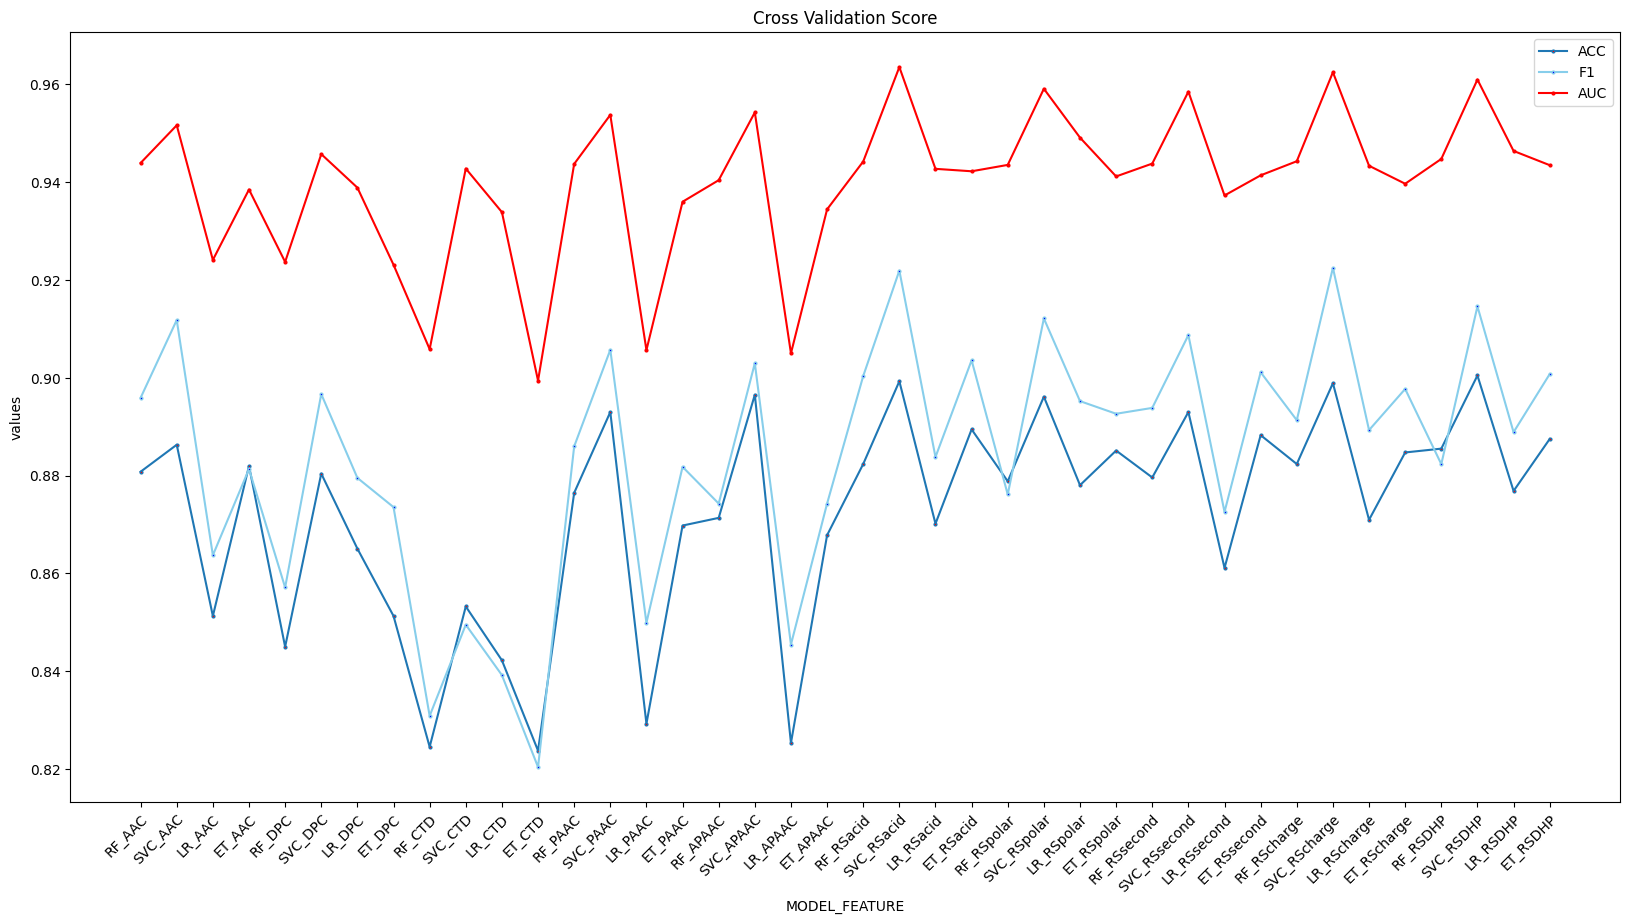

In [34]:

import matplotlib.pyplot as plt
# Get current axis
fig, ax = plt.subplots(1, 1, figsize=(20,10))
# line plot for ACC marks
df_cv_score.plot(kind='line',
        x='MODEL_FEATURE',
        y='ACC',ax=ax, markerfacecolor='red', markersize=2, marker='o')
 
#  line plot for SENS marks
df_cv_score.plot(kind='line', 
        x='MODEL_FEATURE',
        y='F1',
        ax=ax, markerfacecolor='blue', markersize=2, color='skyblue', marker='o')
 
 #  line plot for SENS marks
df_cv_score.plot(kind='line', 
        x='MODEL_FEATURE',
        y='AUC',
        ax=ax, markerfacecolor='red', markersize=2, color='red', marker='o')

plt.xticks(np.arange(len(df_cv_score["MODEL_FEATURE"])), df_cv_score["MODEL_FEATURE"].values)
plt.ylabel("values")
# set the title
plt.title('Cross Validation Score')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# show the plot
plt.show()

In [79]:
testScore = []
clfs_names = ["RF", "SVC", "LR", "ET"]
for feature in featureNames:
    clfs = (RF_clf, SVM_clf, LR_reg, ET_clf) = trainWithSigleFeature(df_train_scaled, feature)
    for idx, clf in enumerate(clfs):
        testAns = (list(testWithSingleFeature(clf, df_test_scaled, feature)))
        testAns.insert(0, (f"{str(clfs_names[idx])}_{feature}"))
        testScore.append(testAns)


In [80]:
df_test_score = pd.DataFrame(testScore, columns=["MODEL_FEATURE", "ACC", "SENS", "SPEC", "MCC", "AUC","F1"])
df_test_score

,MODEL_FEATURE,ACC,SENS,SPEC,MCC,AUC,F1
0,RF_AAC,0.869848,0.949367,0.785714,0.747607,0.927243,0.882353
1,SVC_AAC,0.878525,0.928270,0.825893,0.759692,0.935390,0.887097
2,LR_AAC,0.900217,0.932489,0.866071,0.801419,0.939873,0.905738
3,ET_AAC,0.891540,0.949367,0.830357,0.787279,0.920227,0.900000
4,RF_DPC,0.828633,0.924051,0.727679,0.667033,0.889768,0.847195
5,SVC_DPC,0.854664,0.928270,0.776786,0.715357,0.925981,0.867850
6,LR_DPC,0.880694,0.894515,0.866071,0.761232,0.937255,0.885177
7,ET_DPC,0.815618,0.919831,0.705357,0.642485,0.885407,0.836852
8,RF_CTD,0.759219,0.843882,0.669643,0.522713,0.839634,0.782779
9,SVC_CTD,0.865510,0.898734,0.830357,0.731701,0.916516,0.872951


In [132]:
def plotColumnBar(df , sortWith : str):
    df = df.sort_values([sortWith], ascending=False)
    # Figure Size
    fig, ax = plt.subplots(figsize =(10, 8))
        # Define colors based on prefix
    colors = []
    for name in df["MODEL_FEATURE"]:
        if name.startswith('LR'):
            colors.append('#C94845')
        elif name.startswith('RF'):
            colors.append('#4958B5')
        elif name.startswith('SVC'):
            colors.append('#49D845')
        elif name.startswith('ET'):
            colors.append('#777777')
    # Horizontal Bar Plot
    ax.barh(df["MODEL_FEATURE"], df[sortWith], color = colors)
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.01, i.get_y()+0.5,
                str(round((i.get_width()), 3)),
                fontsize = 8, fontweight ='bold',
                color ='grey')
    plt.xlabel("Values")
    # Add Plot Title
    ax.set_title('Test Result for ' + sortWith)
    # show plot
    plt.show()

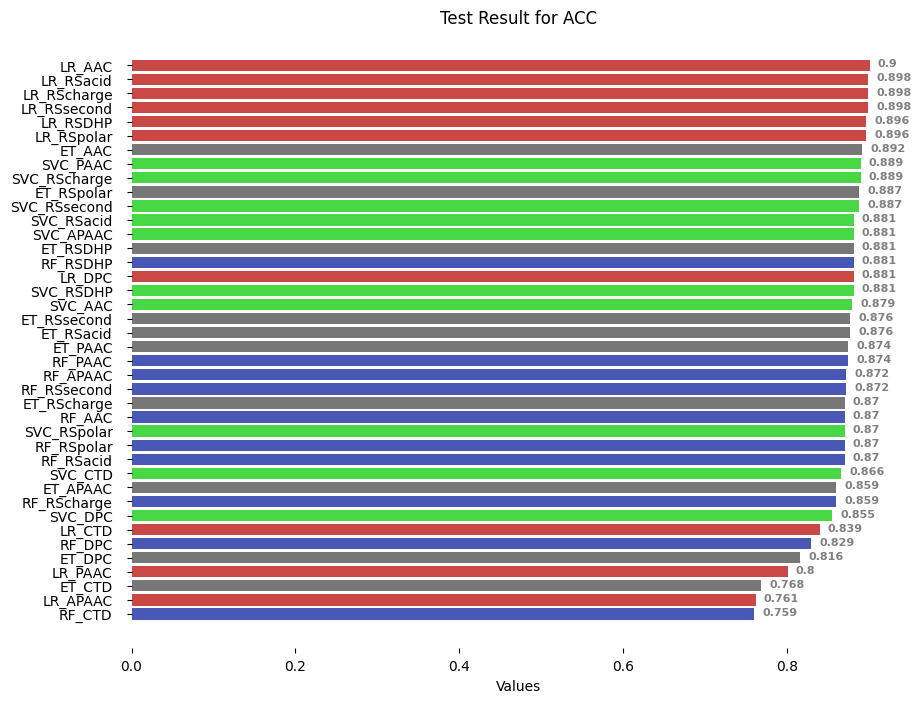

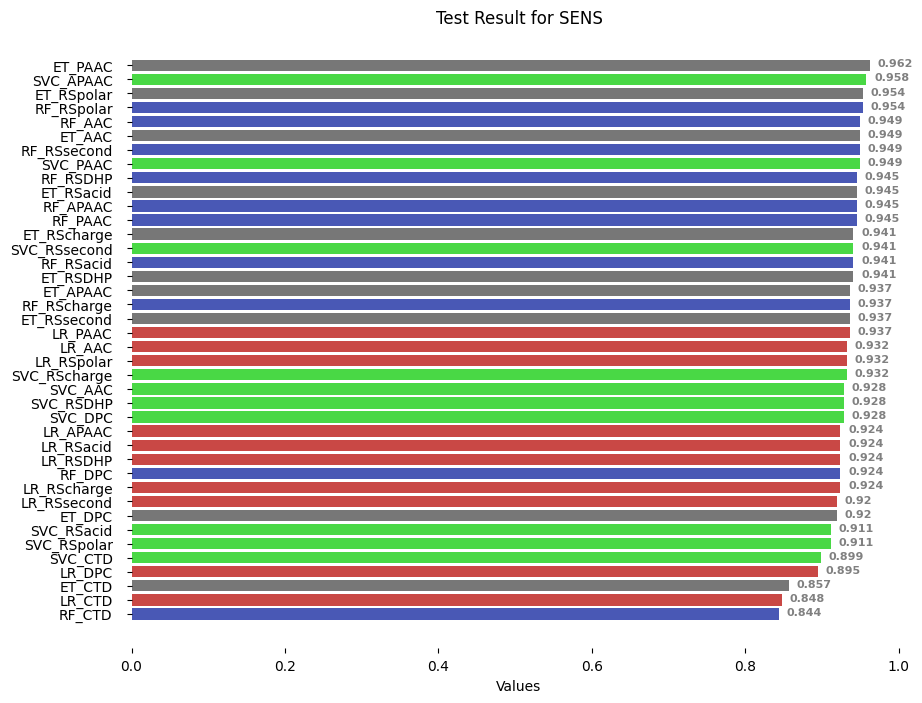

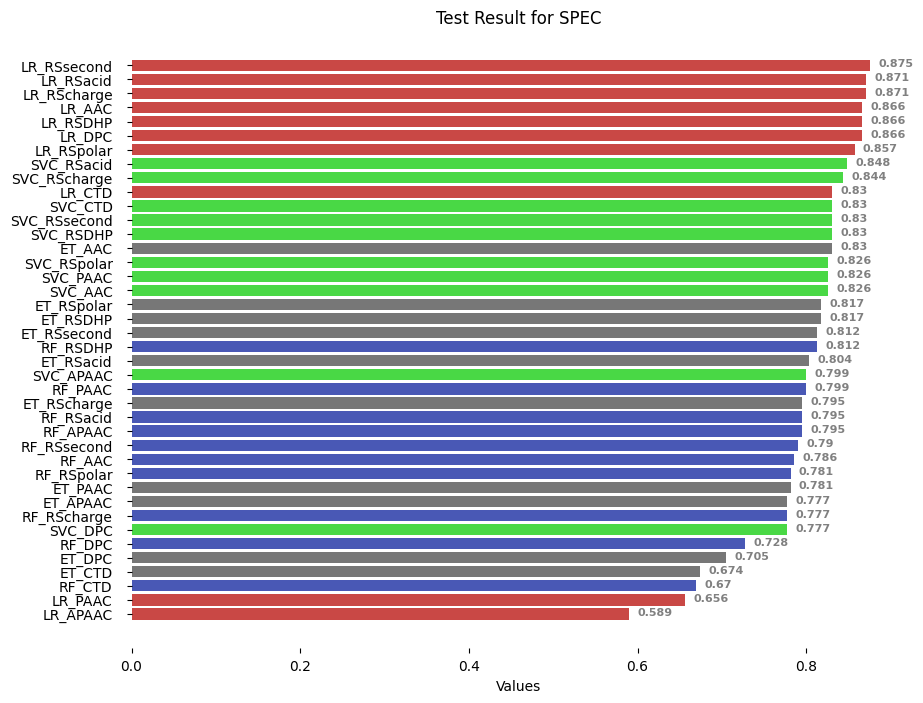

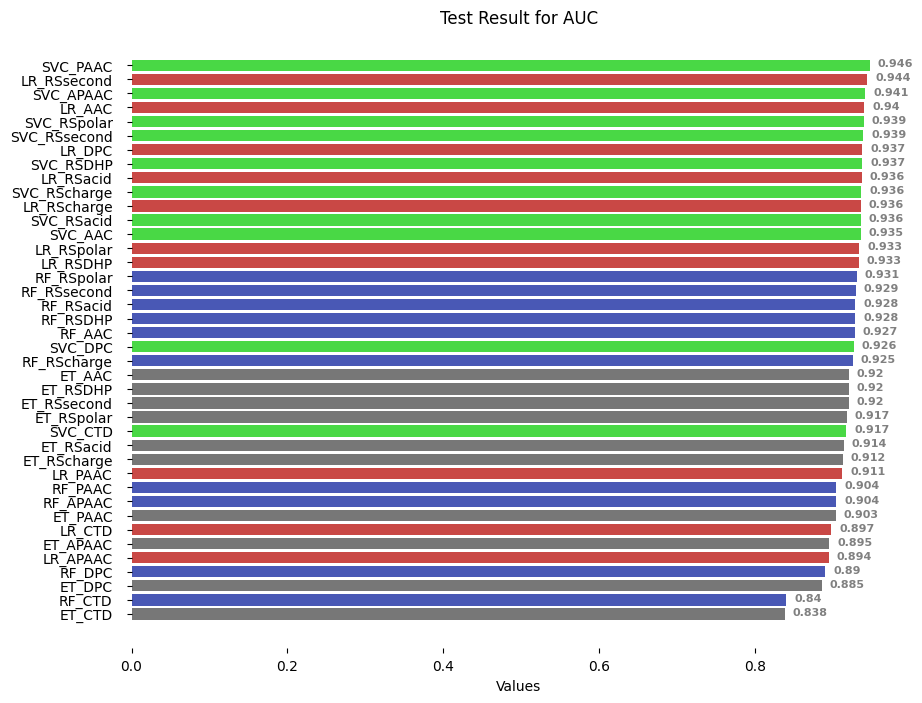

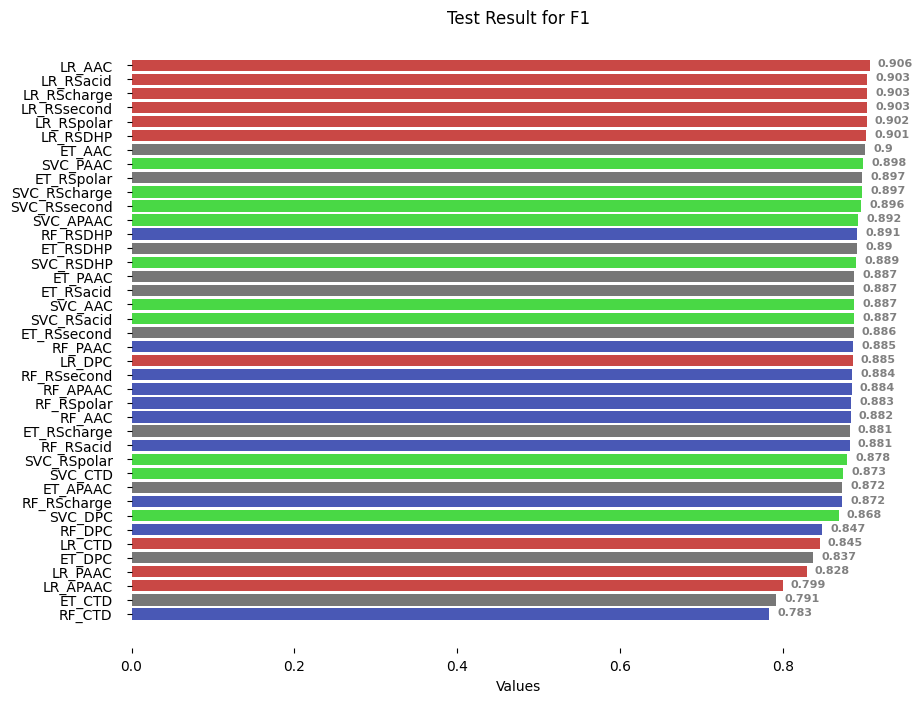

In [133]:
plotColumnBar(df_test_score, "ACC")
plotColumnBar(df_test_score, "SENS")
plotColumnBar(df_test_score, "SPEC")
plotColumnBar(df_test_score, "AUC")
plotColumnBar(df_test_score, "F1")

In [187]:
df_final_scores = pd.DataFrame()
for feature in featureNames:
    df = df_test_score[[val.endswith(f'_{feature}') for val in df_test_score["MODEL_FEATURE"].values]].sort_values(["AUC"], ascending=False).head(1)
    df_final_scores = pd.concat([df_final_scores, df], axis=0, ignore_index=True)
    
df_final_scores = df_final_scores.sort_values(["AUC"], ascending=False).head()
df_final_scores

,MODEL_FEATURE,ACC,SENS,SPEC,MCC,AUC,F1
3,SVC_PAAC,0.889371,0.949367,0.825893,0.783268,0.946485,0.898204
7,LR_RSsecond,0.898048,0.919831,0.875000,0.796318,0.943660,0.902692
4,SVC_APAAC,0.880694,0.957806,0.799107,0.769181,0.940966,0.891945
0,LR_AAC,0.900217,0.932489,0.866071,0.801419,0.939873,0.905738
6,SVC_RSpolar,0.869848,0.911392,0.825893,0.741191,0.938696,0.878049


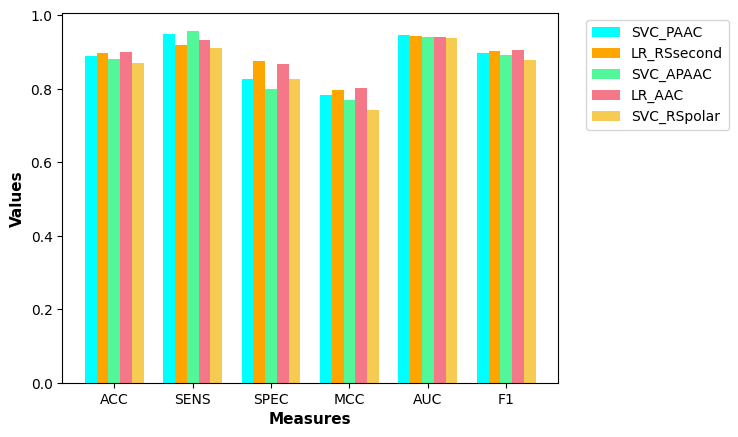

In [208]:
# create data
x = np.arange(6)
width = 0.15

# plot grouped bar chart
# plot data in grouped manner of bar type
plt.bar(x-0.3, df_final_scores.iloc[0,1:].tolist(), width, color='cyan')
plt.bar(x-0.15, df_final_scores.iloc[1,1:].tolist(), width, color='orange')
plt.bar(x, df_final_scores.iloc[2,1:].tolist(), width, color='#52f799')
plt.bar(x+0.15, df_final_scores.iloc[3,1:].tolist(), width, color='#f57889')
plt.bar(x+0.3, df_final_scores.iloc[4,1:].tolist(), width, color='#f7cb52')
plt.xticks(x, ['ACC', 'SENS', 'SPEC', 'MCC','AUC', 'F1'])
# Adding Xticks
plt.xlabel('Measures', fontweight ='bold', fontsize = 11)
plt.ylabel('Values', fontweight ='bold', fontsize = 11)
 
plt.legend(list(df_final_scores["MODEL_FEATURE"]), loc='upper center', bbox_to_anchor=(1.2, 1),
          fancybox=True)
plt.show()
